In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import os
import decoupler as dc
import seaborn as sns
plt.rcParams.update({'font.size': 11})

In [20]:
sns.__version__

'0.13.2'

In [21]:
data_path = '../Data/robustness_fig4/'
runs = os.listdir(data_path)
runs

['cutoff400',
 'cutoff850',
 'cutoff350',
 'cutoff450',
 'original',
 'cutoff600',
 'cutoff900',
 'cutoff200',
 'cutoff50',
 'cutoff150',
 'cutoff550',
 'cutoff300',
 'cutoff650',
 'cutoff700',
 'cutoff950',
 'cutoff500',
 'cutoff0',
 'cutoff100',
 'cutoff750',
 'cutoff800',
 'cutoff250']

In [22]:
# if =='original' then insert at 0
for run in runs:
    if run == 'original':
        runs.insert(0, runs.pop(runs.index(run)))

In [23]:
lr_loadings = {}
W_matrices = []

for run in runs:
    fs = pd.read_csv(data_path + run + '/factor_scores_fig4.csv', index_col='index').drop('Unnamed: 0', axis=1)
    W_matrices.append(fs.values)
    
    lr = pd.read_csv(data_path + run + '/lr_loadings_fig4.csv', index_col='index')
    lr['run'] = run
    lr_loadings[run] = lr

## Correlate Factors & Get order Corresponding Factors

In [25]:
# Assume W_matrices contains all factor loading matrices from different runs
num_runs = len(W_matrices)
mappings = {}
df_list = []

for i in range(1, num_runs):
    mappings_run = {}
    results = []
    for j in range(W_matrices[0].shape[1]):
        max_similarity = -np.inf
        best_match = None
        for k in range(W_matrices[i].shape[1]):
            similarity, pval = pearsonr(W_matrices[0][:, j], W_matrices[i][:, k])
            results.append({'Run': runs[i],
                            'Factor_o': f'Factor{j+1}',
                            'Factor_x': f'Factor{k+1}',
                            'Correlation': similarity,
                            'Pvalue': pval})
            if similarity > max_similarity:
                max_similarity = similarity
                best_match = k
        mappings_run[f'Factor{j+1}'] = f'Factor{best_match+1}'
    mappings[runs[i]]= mappings_run
    df_list.append(pd.DataFrame(results))

score_correlations = pd.concat(df_list, ignore_index=True)
score_correlations['fdr'] = dc.p_adjust_fdr(score_correlations['Pvalue'])
# remove cutoff
score_correlations['Run'] = score_correlations['Run'].str.replace('cutoff', '').astype(int)
score_correlations = score_correlations.sort_values(by='Run')
score_correlations.head()

,Run,Factor_o,Factor_x,Correlation,Pvalue,fdr
136,0,Factor1,Factor2,0.253591,5.872167e-129,7.239658e-129
138,0,Factor2,Factor1,0.962885,0.000000e+00,0.000000e+00
139,0,Factor2,Factor2,-0.497187,0.000000e+00,0.000000e+00
140,0,Factor2,Factor3,-0.193128,1.429323e-74,1.628342e-74
141,0,Factor3,Factor1,-0.390013,4.753258e-317,8.642288e-317


In [26]:
# Pivot the DataFrame for each 'Run'
pivot_data = score_correlations.pivot_table(index="Factor_o", columns=["Run", "Factor_x"], values="Correlation")
pivot_data = pivot_data.T

In [27]:
# Create unique colors for each run
_runs = score_correlations['Run'].unique()
num_runs = len(_runs)
half_runs = num_runs // 2

# Generate colors from two different palettes
colors1 = sns.color_palette("dark", half_runs)
colors2 = sns.color_palette("husl", num_runs - half_runs)
assert len(colors1) + len(colors2) == num_runs

# Assign colors to runs
run_colors = dict(zip(_runs[:half_runs], colors1))
run_colors.update(dict(zip(_runs[half_runs:], colors2)))

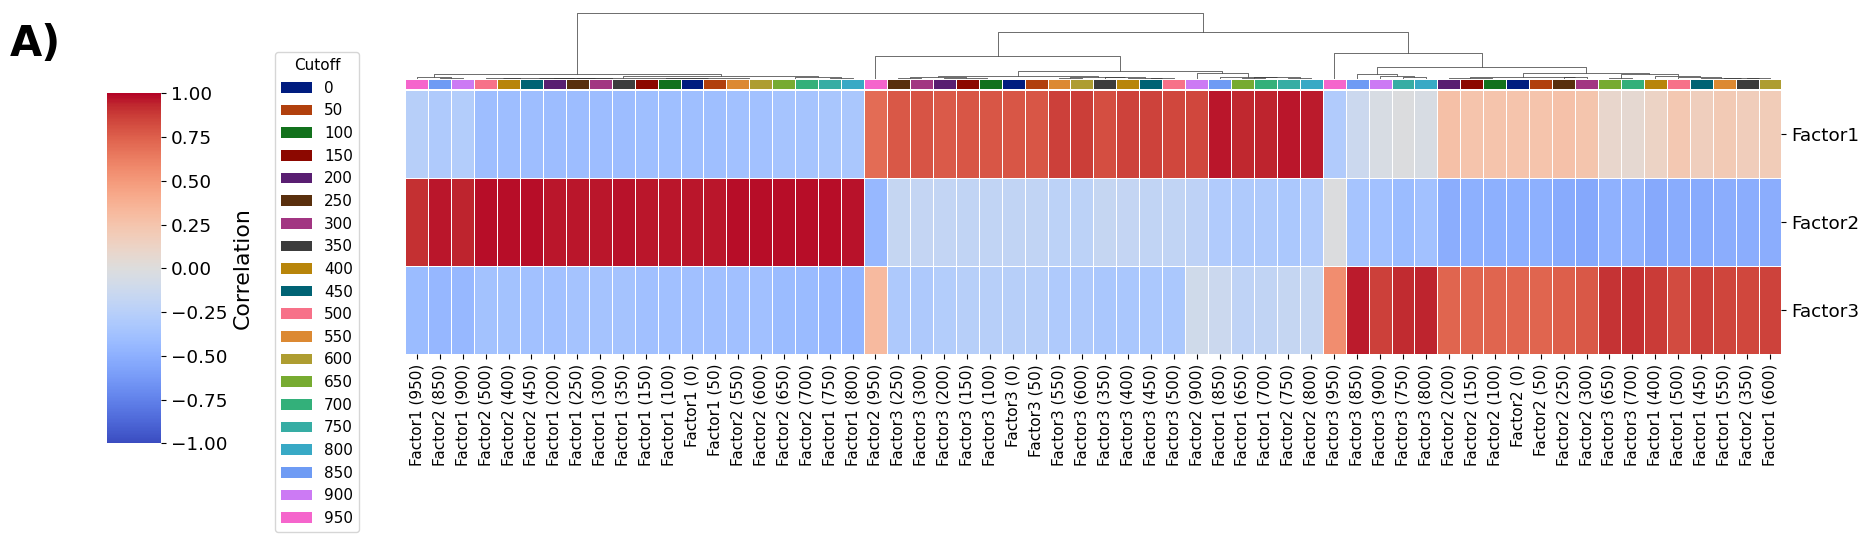

In [28]:
# Create the heatmap
ax1 = sns.clustermap(pivot_data.T,
                     cmap="coolwarm", cbar_kws={'label': 'Correlation'}, linewidths=.5,
                     col_colors=[run_colors[run] for run in pivot_data.index.get_level_values(0)],
                     col_cluster=True, 
                     row_cluster=False, 
                     cbar_pos=(0.035, 0.1, 0.03, 0.70),
                     vmin=-1,
                     vmax=1,
                     row_colors=None,
                     figsize=(18, 5)
                     )

for run in _runs:
    ax1.ax_col_dendrogram.bar(0, 0, color=run_colors[run], label=run, linewidth=0)
    ax1.ax_col_dendrogram.legend(title='Cutoff', 
                                 loc='upper left',
                                 bbox_to_anchor=(-0.1, 0.5), 
                                 title_fontsize='medium',
                                 fontsize='medium',
                                 )

# cbar large font
cbar = ax1.ax_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize='large')
cbar.set_label('Correlation', fontsize='x-large')

ax1.ax_heatmap.set_yticklabels(ax1.ax_heatmap.get_yticklabels(), rotation=0, fontsize='large')

# get the x labels and reformat them
xticks = ax1.ax_heatmap.get_xticklabels()
new_xticks = []
for x in xticks:
    xt = x.get_text().split('-')
    xt = f'{xt[1]} ({xt[0]})'
    x.set_text(xt)
xticks = ax1.ax_heatmap.set_xticklabels(xticks)

# Remove x and y labels
ax1.ax_heatmap.set_xlabel('')
ax1.ax_heatmap.set_ylabel('')

# add A label to the top left
ax1.ax_heatmap.text(-0.25, 1.25, 'A)', transform=ax1.ax_heatmap.transAxes,
                    fontsize=30, fontweight='bold', va='top', ha='right')

plt.savefig('../Plots/Sufig_robustnmfA.pdf', dpi=200)

## Correlate Features of Best Mapped Factors

In [10]:
correlation_loadings = pd.DataFrame(columns=['Run', 'Factor', 'Correlation', 'P-value'])
for run in runs[1:]:
    remap = mappings[run]
    H1 = lr_loadings['original'].copy()
    H2 = lr_loadings[run].copy()
    # subset to common indices
    common = H1.index.intersection(H2.index)
    H1 = H1.loc[common]
    H2 = H2.loc[common]
    for key, value in remap.items():
        corr, pval = pearsonr(H1[key], H2[value])
        correlation_loadings.loc[len(correlation_loadings)] = [run, key, corr, pval]
        
correlation_loadings['Run'] = correlation_loadings['Run'].str.replace('cutoff', '').astype(int)
correlation_loadings = correlation_loadings.sort_values(by='Run')
correlation_loadings.head()

,Run,Factor,Correlation,P-value
47,0,Factor3,0.849966,2.194715e-113
46,0,Factor2,0.992383,0.000000e+00
45,0,Factor1,0.931965,2.381471e-178
23,50,Factor3,0.849966,2.194715e-113
21,50,Factor1,0.931965,2.381471e-178


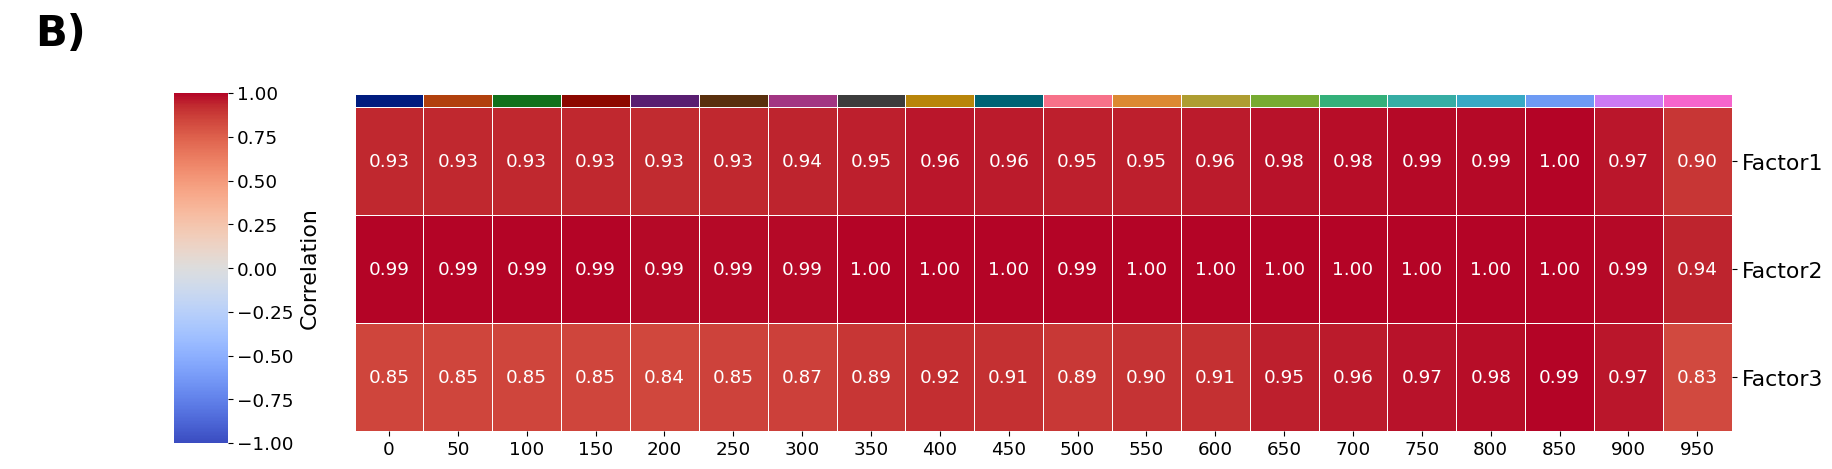

In [11]:
# Create a pivot table for the heatmap
pivot_table = correlation_loadings.pivot(index='Factor', columns='Run', values='Correlation')

ax2 = sns.clustermap(pivot_table, 
                    cmap='coolwarm',
                    annot=True, 
                    fmt=".2f",
                    col_colors=[run_colors[run] for run in _runs],
                    vmin=-1,
                    vmax=1,
                    row_cluster=False,
                    col_cluster=False,
                    cbar_pos=(0.1, 0.1, 0.03, 0.70),
                    figsize=(18, 5),
                    linewidths=.5
                    )

# cbar large font
cbar = ax2.ax_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize='large')
cbar.set_label('Correlation', fontsize='x-large')

# add legend for colors
for run in _runs:
    ax2.ax_col_dendrogram.bar(0, 0, color=run_colors[run], label=run, linewidth=0)
    
ax2.ax_heatmap.set_yticklabels(ax2.ax_heatmap.get_yticklabels(), rotation=0, fontsize='x-large')
ax2.ax_heatmap.set_xticklabels(ax2.ax_heatmap.get_xticklabels(), rotation=0, fontsize='large')

# larger annotation labels
for text in ax2.ax_heatmap.texts:
    text.set_fontsize('large')

# Remove x and y labels
ax2.ax_heatmap.set_xlabel('')
ax2.ax_heatmap.set_ylabel('')

ax2.ax_heatmap.text(-0.2, 1.2, 'B)', transform=ax1.ax_heatmap.transAxes,
                    fontsize=30, fontweight='bold', va='top', ha='right')

plt.savefig('../Plots/Sufig_robustnmfB.pdf', dpi=200)